# E17. 프로젝트 - Movielens 영화 Session Based Recommendation

이번에도 우리는 **Movielens 1M Dataset**을 기반으로, **Session based Recommendation 시스템을 제작**해 보겠습니다.

* 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 **SessionID 대신 UserID 항목이 들어갔다**는 점입니다. 
  - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
  - 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.


* **Rating 정보가 포함**되어 있습니다. 
  - 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 
  - 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 
  - 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.


* Time 항목에는 **UTC time 가 포함**되어, 
  - 1970년 1월 1일부터 경과된 **초단위 시간이 기재**되어 있습니다.


위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. Movielens 데이터셋을 **session based recommendation 관점으로 전처리**하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 **세션단위 정의 과정(길이분석, 시간분석)** 을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|**적절한 epoch**만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 **Recall, MRR이 개선**되는 것이 확인된다.|
|3. **세션정의, 모델구조, 하이퍼파라미터** 등을 변경해서 실험하여 **Recall, MRR 등의 변화추이를 관찰**하였다.|**3가지 이상의 변화를 시도**하고 그 실험결과를 체계적으로 분석하였다.|

* **순위 없는 평가 지표**
  - **정확도 기반 메트릭**
    - MAE, RMSE
    
  - **의사결정 지원 기반 메트릭**
    - **Confusion matrix:**  <img align='center' width='50%' src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcsmX3b%2FbtquhjiOyKI%2FoKNhWcBu2S7GY9JdLnyq4k%2Fimg.png' />
    - **정밀도(Precision) :** 모든 검출 결과물 중에서 옳게 검출한 비율
      - **정밀도(Precision):** $$Precision = \frac{TP}{TP+FP} = \frac{TP}{All~ Detections}$$
      
    - **재현율(Recall) :** 마땅히 검출해내야하는 결과물 중에서 제대로 검출한 것의 비율(검출율)
      - **재현율(Recall):**  $$Recall = \frac{TP}{TP+FN}=\frac{TP}{All~ Ground~ truths}$$
      
      
    - F1점수



* **순위 인식 평가 지표**
  - **이진 관련성(Binary relevance) 기반 메트릭**
    - 항목이 바이너리 의미에서 좋은지 여부를 파악
    - 아이템이 좋은 추천인지 그렇지 않은지에만 관심이 있다
    - Recall@K
    - MRR(평균 상호 순위)
    - MAP(평균 정밀도)
    
  - **유틸리티(Utility) 기반 메트닉**
    - 절대적 또는 상대적인 선함의 측정으로 선 / 나쁜 감각을 확장
    - 실제 랭킹의 위치, 즉 추천된 아이템이 얼마나 좋은지 혹은 어떠한 랭킹보다 더 좋은지 나쁜지에 더 중점을 둔다


* **MRR(Mean Reciprocal Rank) :** 
    - 사용자가 선호하는 아이템이 리스트 중 어디에 위치해 있는지에 중점을 둔 평가 기법
    - "주어지는 쿼리에 대해서 그 쿼리와 정확히 일치하는게 몇번째에 있는가?"를 측정
    - 추천된 리스트가 있고 사용자가 선호하는 아이템이 $k_u$라면, reciprocal rank는 $\frac{1}{k_u}$이다.
    - 모든 쿼리들에 대해서 일치하는 순서의 역순의 평균을 낸 것

    - 이진 관련성 메트릭 계열과 밀접하게 연결
    - **MRR(Mean Reciprocal Rank) :** $$MRR=\frac{1}{\left | Q \right |} \sum_{i=1}^{\left | Q \right |} \frac{1}{rank_i} $$
    - **Reciprocal Rank :**
    Query|	Proposed Results|	Correct response|	Rank|	Reciprocal rank
    :----|:-----|:-----:|:-----:|:-----:
cat|	catten, cati, cats|	cats|	3|	1/3
tori|	torii, tori, toruses|	tori|	2|	1/2
virus|	viruses, virii, viri|	viruses|	1|	1



* **MAP(Average Precision and Mean Average Precision) :**
  - 기본적인 Precision의 경우 모든 에러를 똑같은 에러로 본다.
    - 첫번째 아이템이 틀린 것과 10번째 아이템이 틀린 것을 같은 에러율로 평가한다
  - Average Precision은 상위의 아이템이 틀렸을 경우 더 높은 점수가 깎이게 되고
    - 하위의 아이템이 틀렸을 경우 더 낮은 점수가 깎이게 된다.
  - 특정 컷오프 N까지 권장 항목의 전체 목록을 평가
  - P @ N 의사 결정 지원 메트릭은 n 개의 권장 사항 중 좋은 비율을 계산

## Step 0. 데이터 읽어오기

**Movielens 1M Dataset** 읽어오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    # UserID::MovieID::Rating::Timestamp
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* `data_path / 'ratings.dat'` == `data_path + '/ratings.dat'`
* `pd.read_csv()`
* `.columns`
* `.sort_values()`

In [3]:
# 시간 타입 변경
data['Time'] = data['Time'].map(lambda x : dt.datetime.fromtimestamp(x))
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


* `dt.datetime.fromtimestamp()`

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 
- 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 
  - 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### Step 1-1. 항목별 기본분석

[참고1](https://hogni.tistory.com/5)  
[참고2](https://dbrang.tistory.com/994)

In [4]:
# 데이터의 상위 5개의 행 출력
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


* `.tail()`의 경우 하위 5개의 행 출력 
* 괄호 () 안에 원하는 숫자를 넣으면 그 숫자만큼 행 출력

In [5]:
# 데이터의 (행, 열) 크기 확인
data.shape

(1000209, 4)

In [6]:
# 개별 컬럼 내에 유일한 값 확인
data['UserId'].nunique(), data['MovieId'].nunique(), data['Rating'].nunique()

(6040, 3706, 5)

* 유저의 숫자가 6,040개   
* 아이템의 갯수는 3,706개   
* 등급의 갯수는 5개

* [ml-1m-README.txt](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt)
  - 이 파일에는 약 3,900 편의 영화에 대한 **1,000,209 개의 익명 등급**이 포함되어 있습니다. 
  - 2000 년에 MovieLens에 가입 한 **6,040 명의 MovieLens 사용자**가 만들었습니다.

In [7]:
# 데이터에 대한 전반적인 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB


In [8]:
# 각 칼럼마다 결측치가 몇개 있는지 확인
data.isnull().sum()   # True는 1에 대응하고, False는 0에 대응

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

* 결측값 확인  [참고](https://workingwithpython.com/howtohandlemissingvaluewithpython/)
  - `.isnull().sum()`
  - `.notnull().sum()`
  - `.notna().sum()`

In [9]:
# 요약 통계량
data.describe()

,UserId,ItemId,Rating
count,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00
std,1.728413e+03,1.096041e+03,1.117102e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00
max,6.040000e+03,3.952000e+03,5.000000e+00


In [11]:
# 데이터 수집 기간 
data["Time"].max() - data["Time"].min()

Timedelta('1038 days 18:44:18')

In [12]:
# 등급별 데이터 갯수
data['Rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

In [13]:
data['Rating'].value_counts(normalize=True)

4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: Rating, dtype: float64

약 35%가 4등급, 26%가 3등급, 23%가 5등급 차지함

### Step 1-2. Session Length

* 같은 SessionId를 공유하는 데이터 row의 개수
* 해당 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 등급을 작성했는지)의 의미가 됩니다.

In [14]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [15]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [16]:
session_length.min(), session_length.max()

(20, 2314)

In [17]:
session_length.quantile(0.999)

1343.181000000005

각 세션의 길이는 보통 96 정도입니다.  
약 2.8년 동안 영화등급을 작성하는 것을 생각해보면 이 수치가 그럴듯하게 느껴집니다.  
99.9% 세션은 길이가 1,343 이하입니다.  
길이가 2,314인 세션은 뭔가 이상합니다.

In [18]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


In [19]:
data[data['UserId']==long_session].nunique()

UserId       1
ItemId    2314
Rating       5
Time       684
dtype: int64

유저 1명이 매우 짧은 간격으로 지속적으로 등급 작성을 하고 있습니다.

In [20]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합 계산
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

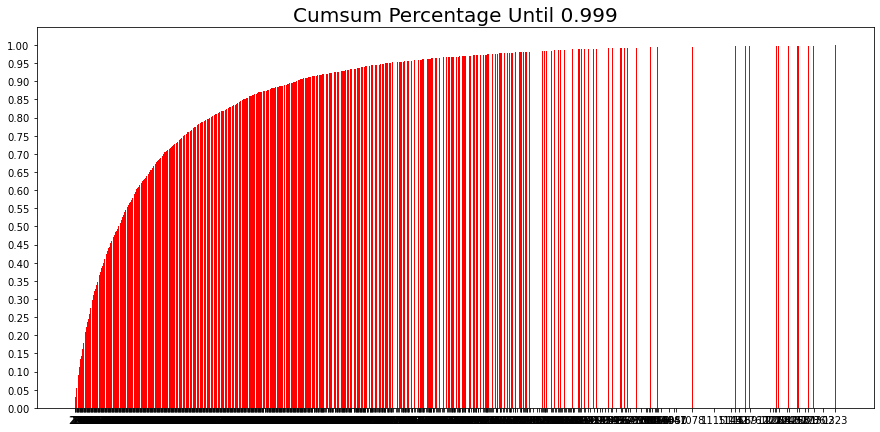

In [21]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Step 1-3. Session Time

데이터가 발생한 시간에 대해 알아보기

In [22]:
# 데이터의 시간 관련 정보를 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print('oldest :', oldest) 
print('latest :', latest)
print(f'수집 기간 : {latest - oldest}')

oldest : 2000-04-26 08:05:32
latest : 2003-03-01 02:49:50
수집 기간 : 1038 days 18:44:18


약 3 년치의 데이터가 있습니다.  
저는 최신 영화 트렌트를 학습하기 위해서 3개월 데이터만 사용하려고 합니다.

In [23]:
month_ago = latest - dt.timedelta(3*30)          # 최종 날짜로부터 3개월 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]            # 방금 구한 날짜 이후의 데이터만 모은다. 
print(month_ago)
data

2002-12-01 02:49:50


,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 17:05:50
5256,36,1701,4,2002-12-22 17:05:50
5184,36,2694,3,2002-12-22 17:08:14
5364,36,3786,4,2002-12-22 17:08:41
5262,36,2369,4,2002-12-22 17:09:24
...,...,...,...,...
984731,5950,3948,4,2003-02-28 03:13:57
984682,5950,3578,4,2003-02-28 03:14:30
984475,5950,3793,3,2003-02-28 03:15:10
984660,5950,3555,2,2003-02-28 03:15:37


In [24]:
data["Time"].min(), data["Time"].max()

(Timestamp('2002-12-01 05:24:52'), Timestamp('2003-03-01 02:49:50'))

In [25]:
data["Time"].max() - data["Time"].min()

Timedelta('89 days 21:24:58')

### Step 1-3. Data Cleansing

너무 적게 등급이 작성된 아이템은 이상한 아이템일 가능성이 있습니다.   
그러므로 길이가 1인 세션은 제거해줍니다.

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('MovieId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['MovieId'].isin(item_use)]
    return data

In [27]:
# data_cleansed = cleanse_recursive(data_ago, shortest=2, least_click=5)

data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
5364,36,3786,4,2002-12-22 17:08:41
5280,36,3174,4,2002-12-22 17:11:25
5222,36,296,5,2002-12-22 17:16:59
5062,36,1266,5,2002-12-22 17:18:29
5076,36,595,4,2002-12-22 17:18:29
...,...,...,...,...
984731,5950,3948,4,2003-02-28 03:13:57
984682,5950,3578,4,2003-02-28 03:14:30
984475,5950,3793,3,2003-02-28 03:15:10
984660,5950,3555,2,2003-02-28 03:15:37


In [28]:
data["Time"].min(), data["Time"].max()

(Timestamp('2002-12-01 13:17:00'), Timestamp('2003-03-01 02:45:20'))

In [29]:
data["Time"].max() - data["Time"].min()

Timedelta('89 days 13:28:20')

## Step 2. 미니 배치의 구성

* 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 
  - Session-Parallel Mini-Batch의 개념에 따라, 
  - 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


* 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 
  - Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.



### Train / Valid / Test split

Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 1주일 기간 동안을 Test로, 2주일전부터 1주일전 까지를 valid set으로 나누겠습니다.

In [ ]:
# day_sec = 24*60*60
# month_ago3 = latest - (3*30*day_sec)       # 최종 날짜로부터 3개월 이전 날짜를 구한다.  
# weeks_ago1 = latest - (7*day_sec)          # 최종 날짜로부터 1주일 이전 날짜를 구한다.
# weeks1_ago2 = latest - (14*day_sec)         # 최종 날짜로부터 2주일 이전 날짜를 구한다.
# weeks2_ago2 = weeks_ago1 - (7*day_sec)         # 최종 날짜로부터 2주일 이전 날짜를 구한다.
# final_time = data['Time'].max()

In [ ]:
# import datetime as dt
# print(day_sec)
# print(month_ago3)
# print(weeks_ago1)
# print(weeks1_ago2)
# print(weeks2_ago2)
# print(dt.timedelta(7))
# print(final_time)

In [30]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
    return before_date, after_date

* `.isin()`
* `.index`

In [31]:
# train/test 분리
train, test = split_by_date(data, n_days=7)

print(train["Time"].max() - train["Time"].min())
print(test["Time"].max() - test["Time"].min())

# train/valid 분리
train, valid = split_by_date(train, n_days=7)
print(train["Time"].max() - train["Time"].min())
print(valid["Time"].max() - valid["Time"].min())

82 days 11:18:16
87 days 22:46:11
74 days 21:45:32
82 days 08:35:01


In [ ]:
# # train/test 분리
# train, test = split_by_date(data_cleansed, n_days=7)

# print(train["Time"].max() - train["Time"].min())
# print(test["Time"].max() - test["Time"].min())

# # train/valid 분리
# train, valid = split_by_date(train, n_days=7)
# print(train["Time"].max() - train["Time"].min())
# print(valid["Time"].max() - valid["Time"].min())

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t UserId: {data["UserId"].nunique()}\n'
          f'\t Items: {data["MovieId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n'
          f'\t Days : {data["Time"].max() - data["Time"].min()}\n')

In [ ]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

In [ ]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

In [ ]:
(1038855549-

### Session-Parallel Mini-Batch

## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

### Data Pipeline

### Modeling

## Step 4. 모델 학습

* 다양한 **하이퍼파라미터를 변경**해 보며 검증해 보도록 합니다. 
  - 실습코드에 언급되었던 **Recall, MRR** 등의 개념들도 함께 관리될 수 있도록 합니다.

### 하이퍼파라미터 변경

### Model Training

## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 **Recall, MRR** 을 확인해 봅니다.
  

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

In [ ]:
<img style='align:center' width='50%' src=''/>

In [ ]:
<div style='text-align:center'> </div>

In [ ]:
<span style='color:red'> </span>

## 회고
* 추천 시스템의 평가지표를 이해하는데 어려웠다.


# End